In [1]:
import maboss
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import os
import shutil

ipylab module is not installed, menus and toolbar are disabled.


In [2]:
def get_phenotype(prob, eps = 0.25): 
    A = prob["RhoA"]
    C = prob["RhoC"]
    delta = C - A

    # Binary classification
    hyper   = (delta > eps).astype(float)
    failed  = (delta < -eps).astype(float)
    normal  = ((abs(delta) <= eps)).astype(float)

    # Threshold-based classifier
    pheno_df = pd.DataFrame({
            "Failed": failed,
            "Hyper": hyper,
            "Normal": normal
    }, index=prob.index)

    return pheno_df

def save_sim_details(outdir, res, name):
    # Save node probabilities
    nodes = res.get_nodes_probtraj().rename_axis('t').reset_index()
    nodes.to_csv(os.path.join(outdir, f"{name}_nodes_probtraj.csv"), index=False)

    # Save state probabilities
    states = res.get_states_probtraj().rename_axis('t').reset_index()
    states.to_csv(os.path.join(outdir, f"{name}_states_probtraj.csv"), index=False)

    # Save the full simulation object
    res.save(os.path.join(outdir, f"{name}_simulation"))


In [3]:
def plot_rhos(name, df, save=False, outdir=None):
    fig, ax = plt.subplots(figsize=(6,4))

    df['RhoA'].plot(ax=ax, label='RhoA')
    df['RhoC'].plot(ax=ax, label='RhoC')

    ax.set_title(f"{name} – RhoA / RhoC activation probabilities")
    ax.set_xlabel('Time')
    ax.set_ylabel('Probability')
    ax.legend()

    plt.tight_layout()

    if save and outdir is not None:
        fname = f"{name}_rhoa_rhoc.png".replace(" ", "_")
        fig.savefig(os.path.join(outdir, fname), dpi=300)

    plt.close(fig)
    return fig
    #plt.show()

    return fig

def plot_delta(name, df, eps, save=False, outdir=None):
    fig, ax = plt.subplots(figsize=(6,4))

    ax.plot(df.index, df["delta"], label="Δ(t)")

    ax.axhline(eps, linestyle="--", label="+ε", color='red')
    ax.axhline(-eps, linestyle="--", label="-ε", color='red')
    ax.axhline(0, linestyle=":", color='grey')

    ax.set_ylim(-0.5, 0.5)
    ax.set_title(f"{name} – Rho balance")
    ax.set_xlabel("Time")
    ax.set_ylabel("Δ = P(RhoC) − P(RhoA)")
    ax.legend()

    plt.tight_layout()

    if save and outdir is not None:
        fname = f"{name}_delta.png".replace(" ", "_")
        fig.savefig(os.path.join(outdir, fname), dpi=300)

    plt.close(fig)
    return fig
    #plt.show()

In [19]:
""" SETUP """
# Setup MaBoSS model
model_file = "../maboss/models/rho.bnd"
cfg_file = "../maboss/models/rho_base.cfg"
model = maboss.load(model_file, cfg_file) # WT
eps = 0.25



In [20]:
""" Create KO / Perturtbations """
from itertools import combinations

nodes = ['DSP', 'TJP1', 'JCAD']
ko_scenarios = {'WT': {"model": model, "ko_combo": () }}

for r in range (1, len(nodes)+1):
    for combo in combinations(nodes, r):
        name = '_'.join(combo)
        #print(f"name: {name} for combo {combo}")
        m = model.copy()
        for node in combo:
            m.mutate(node, "OFF")
            m.update_parameters(**{f"${node}_base": 0.0})
        ko_scenarios[name] = {"model": m, "ko_combo": combo}

ko_scenarios

{'WT': {'model': <maboss.simulation.Simulation at 0x1235b2ce0>,
  'ko_combo': ()},
 'DSP': {'model': <maboss.simulation.Simulation at 0x177e54850>,
  'ko_combo': ('DSP',)},
 'TJP1': {'model': <maboss.simulation.Simulation at 0x11120f100>,
  'ko_combo': ('TJP1',)},
 'JCAD': {'model': <maboss.simulation.Simulation at 0x177e782e0>,
  'ko_combo': ('JCAD',)},
 'DSP_TJP1': {'model': <maboss.simulation.Simulation at 0x157c50220>,
  'ko_combo': ('DSP', 'TJP1')},
 'DSP_JCAD': {'model': <maboss.simulation.Simulation at 0x157c52ce0>,
  'ko_combo': ('DSP', 'JCAD')},
 'TJP1_JCAD': {'model': <maboss.simulation.Simulation at 0x29655da80>,
  'ko_combo': ('TJP1', 'JCAD')},
 'DSP_TJP1_JCAD': {'model': <maboss.simulation.Simulation at 0x157c535e0>,
  'ko_combo': ('DSP', 'TJP1', 'JCAD')}}

In [6]:
""" Simulation run and inital results. """
# Setup result directory
results_dir = "../results/model_two"

if os.path.exists(results_dir):
    shutil.rmtree(results_dir)

os.makedirs(results_dir, exist_ok=True)

node_dfs = {}


for name, info in ko_scenarios.items():
    m = info["model"]
    res = m.run() # Run simulation

    # Create directory for each perturbation scenario. 
    scenario_dir = os.path.join(results_dir, name)
    os.makedirs(scenario_dir, exist_ok=True)

    # Save simulation details
    save_sim_details(scenario_dir, res, name)
    
    # Create node probability dataframe
    prob_df = res.get_nodes_probtraj()
    prob_df['delta'] = prob_df['RhoC'] - prob_df['RhoA']

    # Make plots
    plot_rhos(name=name, df=prob_df, save=True, outdir=scenario_dir) # Plot rho balance table
    plot_delta(name=name, df=prob_df, eps=eps, save=True, outdir=scenario_dir)

    node_dfs[name] = prob_df



In [7]:
""" Summary calculation and result"""
stat_rows = []
balance_cols = []
summary_dir = "../results/model_two/summary"

if os.path.exists(summary_dir):
    shutil.rmtree(summary_dir)

os.makedirs(summary_dir, exist_ok=True)

for name, df in node_dfs.items():
    pheno_df = get_phenotype(df, eps)

    last_row = pheno_df.iloc[[-1]].copy()
    last_row['KO'] = name  # Add the column with the name
    stat_rows.append(last_row)

    delta_col = df['delta'].rename(name)
    balance_cols.append(delta_col)


In [8]:

perbs_summary_df = pd.concat(stat_rows, ignore_index=True).set_index('KO')
perbs_summary_df.to_csv(os.path.join(summary_dir, "KO_summary.csv"), index=True)

phenotype_df = perbs_summary_df.idxmax(axis=1).to_frame(name='Phenotype')
phenotype_df.to_csv(os.path.join(summary_dir, "ss_phenotypes.csv"), index=True)

balance_df = pd.concat(balance_cols, axis=1)
balance_df = balance_df.copy().drop(columns=['DSP_TJP1', 'DSP_TJP1_JCAD'])
balance_df.to_csv(os.path.join(summary_dir, "delta_summary_full.csv"), index=True)

delta_ss = balance_df.iloc[-1].to_frame(name='Delta')
final_ss_table = pd.concat([phenotype_df, delta_ss], axis=1).dropna()
final_ss_table.to_csv(os.path.join(summary_dir, "ss_phenotypes_delta.csv"), index=True)
final_ss_table

,Phenotype,Delta
WT,Normal,-0.003620
DSP,Hyper,0.276847
TJP1,Failed,-0.292858
JCAD,Normal,0.002396
DSP_JCAD,Normal,0.230539
TJP1_JCAD,Normal,-0.218557


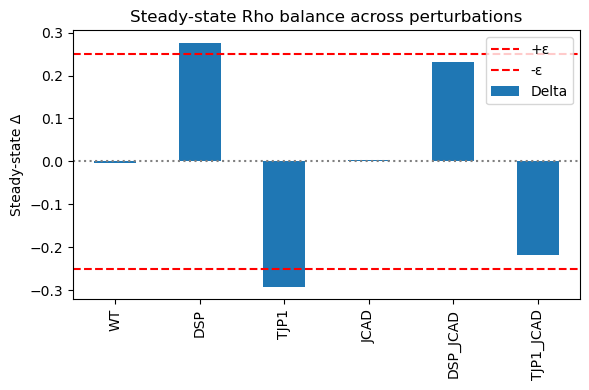

In [9]:

fig, ax = plt.subplots(figsize=(6,4))

delta_ss["Delta"].plot(kind="bar", ax=ax)

ax.axhline(eps, linestyle="--", label="+ε", color='red')
ax.axhline(-eps, linestyle="--", label="-ε", color='red')
ax.axhline(0, linestyle=":", color='grey')

ax.set_ylabel("Steady-state Δ")
ax.set_title("Steady-state Rho balance across perturbations")
ax.legend()

plt.tight_layout()
plt.show()

fig.savefig(os.path.join(summary_dir, f"ss_delta_bar.png"), dpi=300)

plt.close(fig)


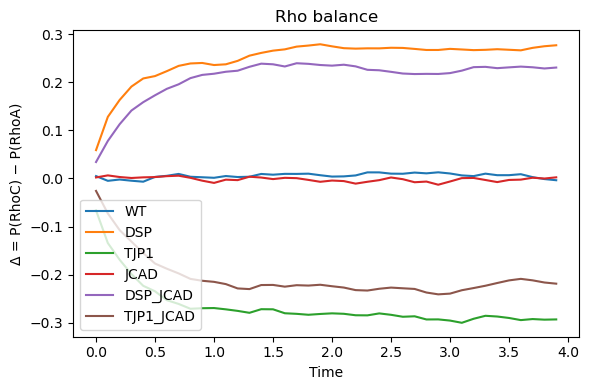

In [10]:
fig, ax = plt.subplots(figsize=(6,4))

ax.plot(balance_df, label=balance_df.columns)

ax.set_title("Rho balance")
ax.set_xlabel("Time")
ax.set_ylabel("Δ = P(RhoC) − P(RhoA)")
ax.legend()

plt.tight_layout()
plt.show()

fig.savefig(os.path.join(summary_dir, f"delta_line.png"), dpi=300)

plt.close(fig)



In [11]:
balance_df

,WT,DSP,TJP1,JCAD,DSP_JCAD,TJP1_JCAD
0.0,0.004985,0.058939,-0.066256,0.002147,0.034228,-0.025821
0.1,-0.004849,0.128064,-0.134144,0.006437,0.078031,-0.072581
0.2,-0.002128,0.163158,-0.168772,0.003045,0.112749,-0.107304
0.3,-0.004632,0.191019,-0.198579,0.001048,0.141224,-0.131144
0.4,-0.006659,0.207878,-0.223028,0.002372,0.158593,-0.154863
0.5,0.003312,0.212810,-0.234411,0.002951,0.172935,-0.176738
0.6,0.005551,0.223061,-0.252897,0.004860,0.186336,-0.187469
0.7,0.009471,0.234015,-0.260675,0.005817,0.195724,-0.197253
0.8,0.003599,0.239032,-0.270711,0.001390,0.208576,-0.208632
0.9,0.002551,0.240068,-0.269576,-0.004541,0.215259,-0.212545


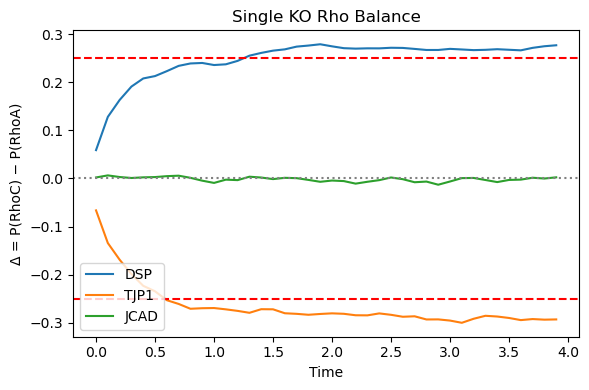

In [12]:
single_ko_df = balance_df[['DSP', 'TJP1', 'JCAD']]
fig, ax = plt.subplots(figsize=(6,4))

ax.plot(single_ko_df, label=single_ko_df.columns)

ax.set_title("Single KO Rho Balance")
ax.set_xlabel("Time")
ax.set_ylabel("Δ = P(RhoC) − P(RhoA)")
ax.axhline(eps, linestyle="--", color='red')
ax.axhline(-eps, linestyle="--", color='red')
ax.axhline(0, linestyle=":", color='grey')
ax.legend()

plt.tight_layout()
plt.show()

fig.savefig(os.path.join(summary_dir, f"single_ko_delta_line.png"), dpi=300)

plt.close(fig)

# Exploratory

In [13]:
# DSP single KO
m = model.copy()
m.mutate("DSP", "OFF")

# DSP + JCAD double KO
m2 = model.copy()
m2.mutate("DSP", "OFF")
m2.mutate("JCAD", "OFF")

# JCAD single KO
m3 = model.copy()
m3.mutate("JCAD", "OFF")

# TJP1 single KO
m4 = model.copy()
m4.mutate("TJP1", "OFF")


# TJP1 + JCAD double KO
m5 = model.copy()
m5.mutate("TJP1", "OFF")
m5.mutate("JCAD", "OFF")

In [14]:
res = m4.run()
prob = res.get_nodes_probtraj()
nodes_df = prob.copy()
nodes_df["delta"] = nodes_df["RhoC"] - nodes_df["RhoA"]
nodes_df.rename_axis('t').reset_index(inplace=True)
# nodes_df_final = nodes_df.iloc[-1]
# nodes_df_final
nodes_df


,DSP,TJP1,JCAD,RhoA,RhoC,delta
0.0,0.495500,0.0,0.499601,0.537517,0.473918,-0.063599
0.1,0.495501,0.0,0.499599,0.582100,0.450307,-0.131793
0.2,0.495499,0.0,0.499599,0.609883,0.433886,-0.175997
0.3,0.495500,0.0,0.499600,0.624532,0.423836,-0.200696
0.4,0.495501,0.0,0.499600,0.634554,0.417386,-0.217168
0.5,0.495501,0.0,0.499601,0.643335,0.411372,-0.231963
0.6,0.495499,0.0,0.499598,0.652230,0.408439,-0.243791
0.7,0.495502,0.0,0.499601,0.659974,0.407188,-0.252786
0.8,0.495499,0.0,0.499599,0.667722,0.405087,-0.262635
0.9,0.495500,0.0,0.499599,0.670438,0.400704,-0.269734


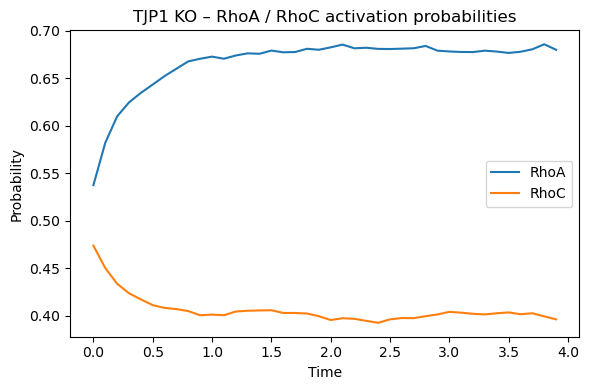

In [15]:
fig, ax = plt.subplots(figsize=(6,4))

nodes_df["RhoA"].plot(ax=ax, label="RhoA")
nodes_df["RhoC"].plot(ax=ax, label="RhoC")

ax.set_title("TJP1 KO – RhoA / RhoC activation probabilities")
ax.set_xlabel("Time")
ax.set_ylabel("Probability")
ax.legend()

plt.tight_layout()
plt.show()


In [16]:
fig = plot_rhos('TJP1 KO', nodes_df)
fig.show()

/var/folders/6g/q6rvxn7j5zz8mmsx5fy77vj80000gn/T/ipykernel_54676/502176354.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


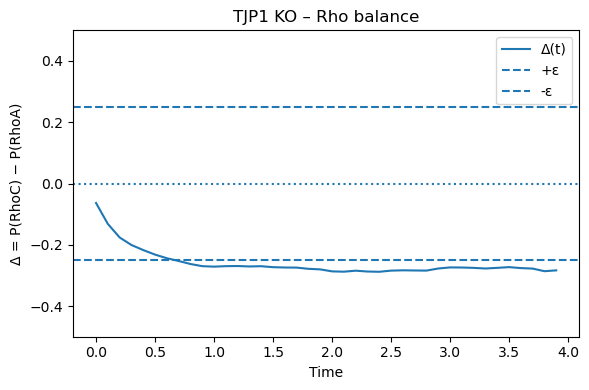

In [17]:

fig, ax = plt.subplots(figsize=(6,4))

ax.plot(nodes_df.index, nodes_df["delta"], label="Δ(t)")

ax.axhline(eps, linestyle="--", label="+ε")
ax.axhline(-eps, linestyle="--", label="-ε")
ax.axhline(0, linestyle=":")

ax.set_ylim(-0.5, 0.5)
ax.set_title("TJP1 KO – Rho balance")
ax.set_xlabel("Time")
ax.set_ylabel("Δ = P(RhoC) − P(RhoA)")
ax.legend()

plt.tight_layout()
plt.show()


In [18]:
A = nodes_df["RhoA"]
C = nodes_df["RhoC"]
delta = C - A
eps = 0.25

# Binary classification
hyper_bin   = (delta > eps).astype(float)
failed_bin  = (delta < -eps).astype(float)
normal_bin  = ((abs(delta) <= eps)).astype(float)

pheno_df = pd.DataFrame({
        "Failed": failed_bin,
        "Hyper": hyper_bin,
        "Normal": normal_bin
}, index=nodes_df.index)
pheno_df

,Failed,Hyper,Normal
0.0,0.0,0.0,1.0
0.1,0.0,0.0,1.0
0.2,0.0,0.0,1.0
0.3,0.0,0.0,1.0
0.4,0.0,0.0,1.0
0.5,0.0,0.0,1.0
0.6,0.0,0.0,1.0
0.7,1.0,0.0,0.0
0.8,1.0,0.0,0.0
0.9,1.0,0.0,0.0


## Threshold (eps) Method

Pros:

Very clear biological interpretation: hyper only when RhoC is significantly higher than RhoA.

Works well to capture knockout phenotypes in line with biology.

Easy to adjust eps for sensitivity.

Cons:

Binary: no information on magnitude of dominance, loses fine probabilistic detail.

Requires choosing eps, which may need calibration.

Use case: Best for categorical phenotypes where you want clear assignment (e.g., WT = Normal, DSP KO = Hyper).

In [122]:
delta = nodes_df["delta"]

eps = 0.3
hyper   = (delta > eps).astype(float)  # RhoC significantly higher than RhoA
failed  = (delta < -eps).astype(float) # RhoA significantly higher than RhoC
normal  = ((abs(delta) <= eps)).astype(float)

pd.DataFrame({
        "Failed": failed,
        "Hyper": hyper,
        "Normal": normal
}, index=nodes_df.index)

,Failed,Hyper,Normal
0.0,0.0,0.0,1.0
0.1,0.0,0.0,1.0
0.2,0.0,0.0,1.0
0.3,0.0,0.0,1.0
0.4,0.0,0.0,1.0
0.5,0.0,0.0,1.0
0.6,0.0,0.0,1.0
0.7,0.0,1.0,0.0
0.8,0.0,1.0,0.0
0.9,0.0,1.0,0.0


## Fractional Dominance Method

Pros:

Probabilistic, continuous, captures the relative contributions of RhoA vs RhoC.

Works well if both nodes have low-level fluctuations — gives smooth phenotypes.

Automatically bounded [0,1].

Cons:

Small numbers can cause numerical instability (division by tiny sums).

Doesn’t explicitly threshold what “dominance” means; even tiny differences contribute to hyper/failed.

Use case: Good for time-course or probabilistic weighting, not strict binary phenotype.

In [123]:
A = nodes_df["RhoA"]
C = nodes_df["RhoC"]
delta = C - A

hyper = (C / (A + C)).clip(0, 1)
failed  = (A / (A + C)).clip(0, 1)
normal  = 1 - hyper - failed

pd.DataFrame({
        "Failed": failed,
        "Hyper": hyper,
        "Normal": normal
}, index=nodes_df.index).tail()

,Failed,Hyper,Normal
3.5,0.227395,0.772605,8.326673e-17
3.6,0.226936,0.773064,5.551115e-17
3.7,0.226157,0.773843,0.000000e+00
3.8,0.225420,0.774580,-5.551115e-17
3.9,0.223817,0.776183,-2.775558e-17


In [ ]:
# # Probabilistic weighting
# total = A + C + 1e-9
# hyper_prob = (C / total) * hyper_bin
# failed_prob = (A / total) * failed_bin
# normal_prob = normal_bin

# prob_df = pd.DataFrame({
#         "Failed": failed_prob,
#         "Hyper": hyper_prob,
#         "Normal": normal_prob
# }, index=nodes_df.index)
# prob_df

,Failed,Hyper,Normal
0.0,0.0,0.0,1.0
0.1,0.0,0.0,1.0
0.2,0.0,0.0,1.0
0.3,0.0,0.0,1.0
0.4,0.0,0.0,1.0
0.5,0.0,0.0,1.0
0.6,0.0,0.0,1.0
0.7,0.0,0.0,1.0
0.8,0.0,0.0,1.0
0.9,0.0,0.0,1.0


,<nil>,DSP,DSP -- JCAD,DSP -- JCAD -- RhoA,DSP -- JCAD -- RhoC,DSP -- JCAD -- RhoC -- RhoA,DSP -- RhoA,DSP -- RhoC,DSP -- RhoC -- RhoA,DSP -- TJP1,DSP -- TJP1 -- JCAD,DSP -- TJP1 -- JCAD -- RhoA,DSP -- TJP1 -- JCAD -- RhoC,DSP -- TJP1 -- JCAD -- RhoC -- RhoA,DSP -- TJP1 -- RhoA,DSP -- TJP1 -- RhoC,DSP -- TJP1 -- RhoC -- RhoA,JCAD,JCAD -- RhoA,JCAD -- RhoC,JCAD -- RhoC -- RhoA,RhoA,RhoC,RhoC -- RhoA,TJP1,TJP1 -- JCAD,TJP1 -- JCAD -- RhoA,TJP1 -- JCAD -- RhoC,TJP1 -- JCAD -- RhoC -- RhoA,TJP1 -- RhoA,TJP1 -- RhoC,TJP1 -- RhoC -- RhoA
3.5,0.015748,0.010566,0.003547,0.076915,0.007949,0.035789,0.057341,0.029609,0.028283,0.008223,0.000547,0.018417,0.016649,0.088286,0.040519,0.038080,0.039177,0.016038,0.044895,0.042696,0.022171,0.040312,0.046365,0.021775,0.009556,0.002701,0.006588,0.080228,0.036583,0.028633,0.057131,0.028680
3.6,0.016334,0.010582,0.003719,0.075788,0.007012,0.037681,0.056003,0.029707,0.029508,0.007844,0.000628,0.018177,0.016590,0.088505,0.041081,0.038128,0.038947,0.017337,0.043710,0.042151,0.022603,0.039761,0.045997,0.022108,0.010111,0.002996,0.007182,0.079251,0.036672,0.027501,0.056989,0.029399
3.7,0.016711,0.011085,0.003507,0.075189,0.008114,0.037390,0.054686,0.029954,0.030075,0.007724,0.000793,0.017767,0.018216,0.087125,0.041310,0.038761,0.038206,0.017664,0.042047,0.042262,0.023827,0.039640,0.045774,0.022076,0.009733,0.002501,0.006581,0.078919,0.038099,0.026443,0.056717,0.031107
3.8,0.017092,0.011847,0.003260,0.074747,0.008472,0.037721,0.053410,0.030590,0.029953,0.007926,0.000453,0.018703,0.018669,0.086074,0.039925,0.037804,0.040345,0.018064,0.041677,0.041883,0.024175,0.039848,0.045931,0.021328,0.009334,0.002804,0.006050,0.078208,0.039038,0.026388,0.056622,0.031655
3.9,0.015938,0.012523,0.003193,0.073853,0.007851,0.039303,0.052699,0.030652,0.029926,0.007959,0.000987,0.018854,0.017821,0.086239,0.040534,0.037674,0.039833,0.018074,0.041522,0.041244,0.024960,0.041130,0.046427,0.020706,0.009580,0.002600,0.005667,0.078623,0.039210,0.026349,0.056722,0.031348
